<a href="https://colab.research.google.com/github/kylehounslow/bmw_2019/blob/master/notebooks/object_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Object Detection and 3D measurement from point cloud  
___
Topics covered in this notebook:  
* Importing code from Github to work with Colab  
* Object detection with YOLOv3  
* Working with Point cloud data
* Combining object detection and point clouds to localize objects in 3D space.

## Environment setup

### Make sure our runtime has a GPU attached usig `nvidia-smi` shell command

In [1]:
!nvidia-smi

Wed Jul 24 18:45:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### clone the `bmw_2019` repository to our colab instance and install the required libraries

---



In [2]:
!rm -rf bmw_2019 && git clone --quiet https://github.com/kylehounslow/bmw_2019.git
!pip install --quiet -r bmw_2019/requirements_colab.txt

     |████████████████████████████████| 1.8MB 3.4MB/s 
     |████████████████████████████████| 3.7MB 42.1MB/s 


### Import the YOLOV3 module and some other dependencies

In [3]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import youtube_dl
from google.colab.files import download
from bmw_2019.models.keras_yolov3 import YOLOV3
from bmw_2019 import util
plt.style.use('default')
%matplotlib inline

Using TensorFlow backend.


## Section 1: Object Detection

### Instatiate the detector  
The `__init__` function for `YOLOV3` will take care of downloading the pretrained model weights and setting up the necessary variables for inference.  
See yolov3 source code [here](https://github.com/kylehounslow/bmw_2019/blob/master/models/keras_yolov3/src/yolo.py)

In [4]:
detector = YOLOV3()

weights file not found. Downloading...

W0724 18:45:29.259968 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 18:45:29.261259 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0724 18:45:29.272750 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Done.
Done.


W0724 18:45:31.073934 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0724 18:45:31.078882 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 18:45:32.889960 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0724 18:45:38.162152 139738238752640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor in

/content/bmw_2019/models/keras_yolov3/src/model_data/yolo.h5 model, anchors, and classes loaded.


W0724 18:45:43.793478 139738238752640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Render the YOLOV3 Model Architecture a notebook cell
Note: You'll need to zoom in!

In [0]:
import numpy as np
import tensorflow as tf
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
show_graph(tf.get_default_graph())

### Download image from URL and run detection
 The following defines a form widget for user input, downloads image and runs inference 

In [0]:
#@title ## Detect objects from image url
#@markdown ### Enter an image URL:
url = "https://i.ytimg.com/vi/gcI1BP1SlCk/maxresdefault.jpg" #@param {type:"string"}
img = util.download_image(url)
plt.figure(figsize=(18,12))
plt.title("Original Image")
plt.imshow(img)
plt.show()
detections = detector.detect(image=img)
img_draw = detector.draw_detections(img, detections)
plt.figure(figsize=(18,12))
plt.title("Detections")
plt.imshow(img_draw)

### Or we can capture image from client webcam

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture and Detect';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    img = Image.open(filename)
    img = np.array(img)
    detections = detector.detect(image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_draw = detector.draw_detections(img, detections)
    plt.figure(figsize=(12,8))
    plt.imshow(img_draw)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
    print(str(err))

### Or we can upload an image and run detection 

In [0]:
from PIL import Image
import cv2
from google.colab import files
def upload_detect_show(detector):
    uploaded_files = files.upload()
    image_filenames = list(uploaded_files.keys())
    for image_filename in image_filenames:
        image = Image.open(image_filename)
        detections = detector.detect(image=image)
        img_draw = detector.draw_detections(image, detections)
        return Image.fromarray(img_draw)
upload_detect_show(detector=detector)

## Section 2: Working with Depth data
Fusing other sensory data (lidar, thermal infrared, GIS) with computer vision techniques unlocks many possibilities.  
In industry we often encounter use-cases where a monocular or stereo camera is simply not enough sensory input to get the results we're looking for. In the following section we'll learn to work with point cloud data

### Load RGBD image

In [6]:
rgbd = cv2.imread('./bmw_2019/notebooks/data/rgbd.png', cv2.IMREAD_UNCHANGED)  # NOTE: IMREAD_UNCHANGED loads image as its original uint16 dtype
print(rgbd.shape, rgbd.dtype)

(720, 1280, 4) uint16


### Exercise: Split the RGBD image into RGB + Depth and plot using `plt.imshow`
Recall that numpy images are indexed by `[row, col, channel]`

<img src="https://miro.medium.com/max/1000/1*Ikn1J6siiiCSk4ivYUhdgw.png" style="height:50px; width:50px">

(720, 1280, 3) uint16 (720, 1280) uint16


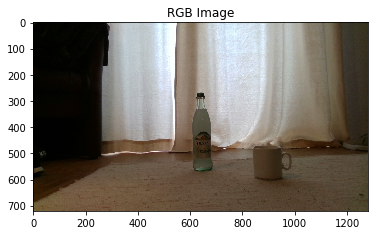

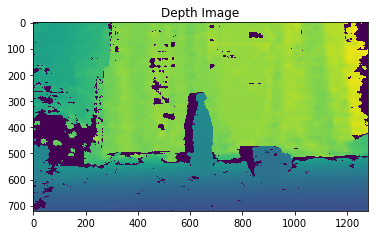

In [7]:
rgb = rgbd[:, :, :3]  # first 3 channels is RGB
depth = rgbd[:, :, -1]  # last channel is depth

print(rgb.shape, rgb.dtype, depth.shape, rgb.dtype)

plt.title("RGB Image")
plt.imshow(rgb)
plt.show()
plt.title("Depth Image")
plt.imshow(depth)
plt.show()

### Load Pointcloud data

In [8]:
point_cloud = np.load('./bmw_2019/notebooks/data/point_cloud.npy')
print(point_cloud.shape, point_cloud.dtype)
print(point_cloud[:5])  # print first 5 elements

(921600, 3) float32
[[-0.9208603   0.5330576   1.3330001 ]
 [-0.9166588   0.531458    1.3290001 ]
 [-0.9131547   0.53025836  1.3260001 ]
 [-0.9117198   0.53025836  1.3260001 ]
 [-0.90753883  0.52865875  1.322     ]]


### Subsample the point cloud and plot in 3d
Note: The point cloud data is in left-hand coordinate system:  
* **x-axis:** left/right   
* **y-axis:** up/down  
* **z-axis:** +/- depth  
  
<img src="https://docs.microsoft.com/en-us/windows/win32/direct3d9/images/leftrght.png">
  
Matplotlib defaults to left-hand coord system with y/z axis swapped, so be sure to swap them when plotting

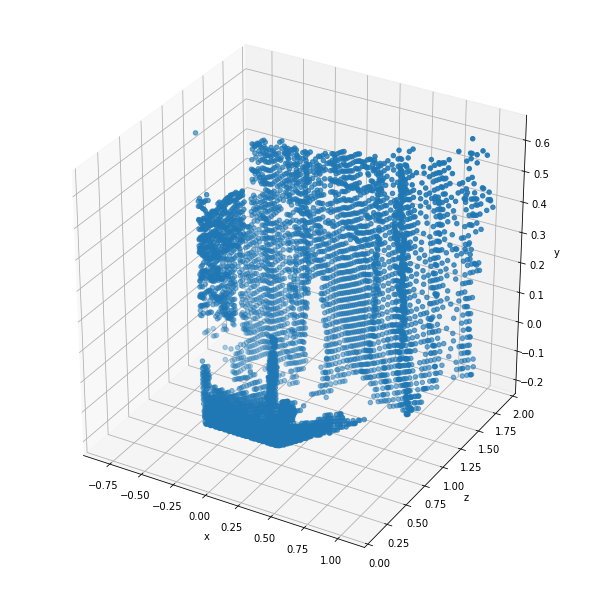

In [9]:
subsample_rate = 150
x_subsample = point_cloud[:,0][1::subsample_rate]
y_subsample = point_cloud[:,1][1::subsample_rate]
z_subsample = point_cloud[:,2][1::subsample_rate]
fig = plt.figure(figsize=(8, 8))
ax3d = Axes3D(fig)
ax3d.set_xlabel("x")
ax3d.set_ylabel("z")
ax3d.set_zlabel("y")
ax3d.set_xlim(x_subsample.min(), x_subsample.max())
ax3d.set_ylim(z_subsample.min(), 2)  # only look 2 meters in z-direction
ax3d.set_zlim(y_subsample.min(), y_subsample.max())
ax3d.scatter(xs=x_subsample, ys=z_subsample, zs=y_subsample)

### Looks a bit confusing from this angle. Rotate the plot about y-axis to look down -x axis (side view)

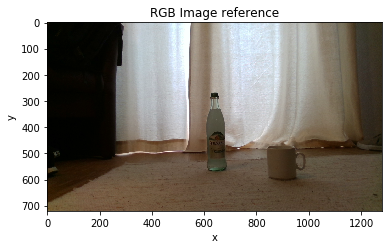

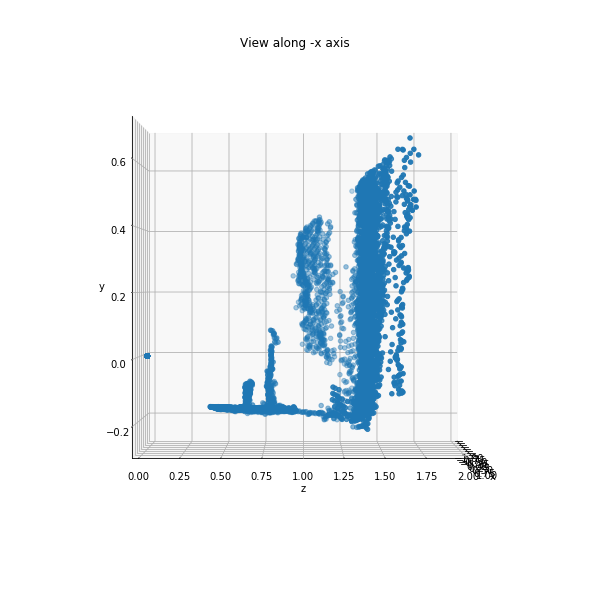

In [10]:
plt.title("RGB Image reference")
plt.xlabel("x")
plt.ylabel("y")
plt.imshow(rgb)
plt.show()
fig = plt.figure(figsize=(8, 8))
ax3d = Axes3D(fig)
ax3d.set_title("View along -x axis")
ax3d.set_xlabel("x")
ax3d.set_ylabel("z")
ax3d.set_zlabel("y")
ax3d.set_xlim(-1, 1)
ax3d.set_ylim(z_subsample.min(), 2)
ax3d.scatter(xs=x_subsample, ys=z_subsample, zs=y_subsample)
ax3d.view_init(elev=0, azim=0) # rotate the axes to look down -x axis

### Rotate 90 degrees about x-axis to look down -y axis (top-down view) 

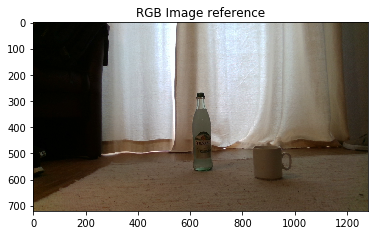

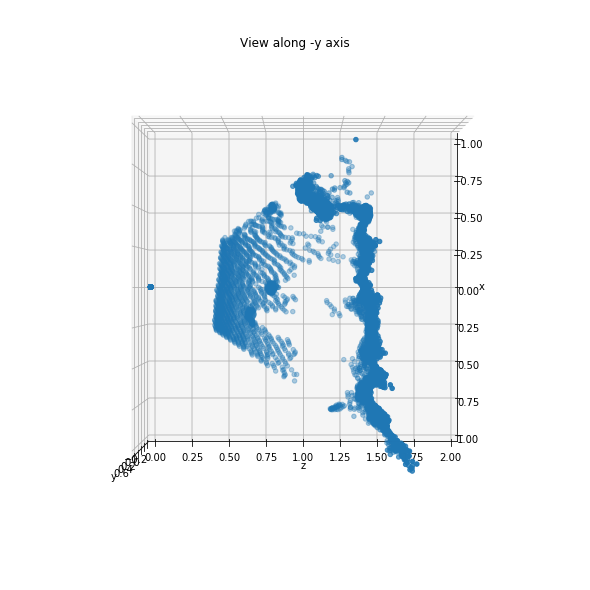

In [11]:
plt.title("RGB Image reference")
plt.imshow(rgb)
plt.show()
fig = plt.figure(figsize=(8, 8))
ax3d = Axes3D(fig)
ax3d.set_title("View along -y axis")
ax3d.set_xlabel("x")
ax3d.set_ylabel("z")
ax3d.set_zlabel("y")
ax3d.set_xlim(-1, 1)
ax3d.set_ylim(z_subsample.min(), 2)
ax3d.scatter(xs=x_subsample, ys=z_subsample, zs=y_subsample)
# rotate the axes to look down -x axis
ax3d.view_init(elev=90,  azim=0)

## Coding Challenge 1: Measure approximate distance to the glass bottle using the depth image
Measured with a ruler the distance is about **~800mm**

### We'll start by locating the bottle in the RGB image using object detection
This part is done for you. Simply execute cell below

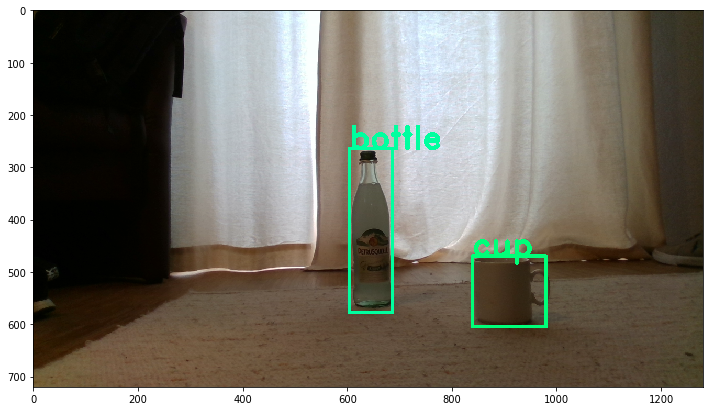

In [12]:
img_rgb = rgb.astype("uint8")  # CNN input must be unsigned 8-bit integer
detections = detector.detect(img_rgb)
for det in detections:
    bbox = det.bbox
    label = det.label
    color = det.color
    cv2.rectangle(img_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=color, thickness=5)
    cv2.putText(img_rgb, str(label), (bbox[0], bbox[1]), 2, 2, color=color, thickness=5)
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)

### Time to code! Find approximate distance to the bottle using the depth image
Some information to help get started:  
* The depth image contains unsigned 16-bit values rerpresenting the depth at each pixel coordinate in the image.  
* The scale of the depth values are such that `1unit == 1mm`.
* Each detection has a corresponding bounding box (`bbox`) and label. 
* bounding box coordinates are in `[x1, y1, x2, y2]` format or `[left, top, bottom, right]`

#### Crop the bottle in the depth image

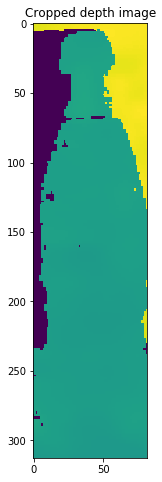

In [13]:
#@title
# select the detection which has `bottle` label
bottle = None
for det in detections:
    if det.label == 'bottle':
        bottle = det
# crop the depth image using bounding box coordinates
x1, y1, x2, y2 = bottle.bbox
depth_crop = depth[y1:y2, x1:x2].copy()
# plot the cropped depth image
plt.figure(figsize=(8,8))
plt.title("Cropped depth image")
plt.imshow(depth_crop)
plt.show()

#### Plot the histogram of the depth image

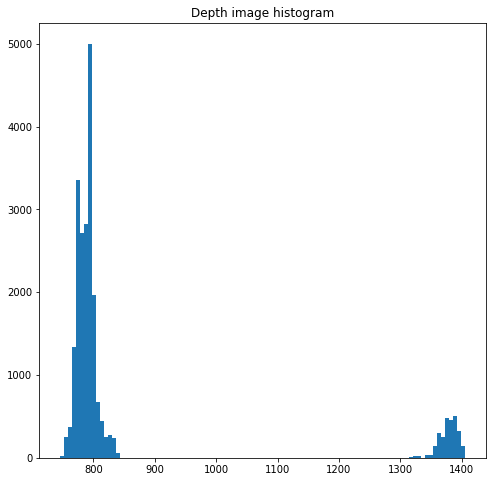

In [14]:
depth_crop = depth_crop[np.nonzero(depth_crop)]  # first remove zero values from depth
# plot the histogram and obtain the counts and values
num_bins = 100
plt.figure(figsize=(8,8))
plt.title("Depth image histogram")
counts, values, _ = plt.hist(depth_crop.flatten(), bins=num_bins)

#### Filter the part of the histogram which is most likely to contain the bottle
This part is a bit tricky. Of course you could manually enter values to filter, however we'd like to do this programmatically.   
`hint: np.argmax(a) gives index of largest element in an array`

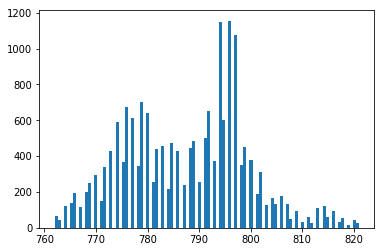

In [15]:
window = 30  # a bit of a cheat but let's allow it
peak_idx = np.argmax(counts)  # get index of largest counts
peak_counts, peak_val = counts[peak_idx], values[peak_idx]  # get largest value
depth_bottle = depth_crop.copy()
depth_bottle[depth_bottle < peak_val - window] = 0  # filter on either side of the peak by a defined window
depth_bottle[depth_bottle > peak_val + window] = 0
depth_bottle = depth_bottle[np.nonzero(depth_bottle)]  # remove zero valued depth
counts_2, values_2, _ = plt.hist(depth_bottle.flatten(), bins=100)

In [16]:
dist = np.mean(values_2)
print("approimate distance is: {}mm".format(round(dist)))

approimate distance is: 792.0mm


## Coding Challenge 2: Measure height and width of glass bottle using the point cloud
Measured with a ruler the dimensions are about **~65mm x 265mm**

#### Reshape the point cloud to the same dimensions as rgb image

W0724 18:50:45.108594 139738238752640 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(313, 82, 3)


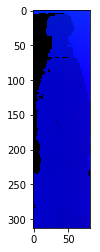

In [20]:
# reshape pointcloud from (N, 3) to (height, width, 3) so we may crop using bounding box
pc_res = point_cloud.reshape(rgb.shape)
# crop the point cloud using detection bounding box
pc_crop = pc_res[y1:y2, x1:x2, :].copy()
print(pc_crop.shape)
plt.imshow(pc_crop)

#### Plot in 3D

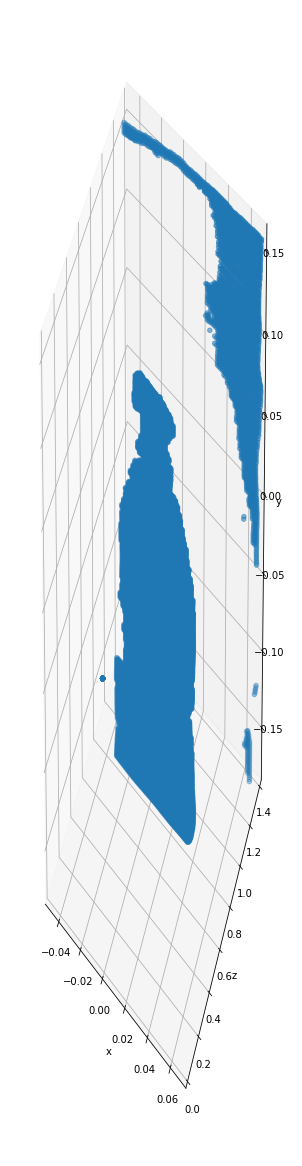

In [22]:
from mpl_toolkits.mplot3d import Axes3D
points3d = pc_crop.reshape(-1, 3)
xs = points3d[:,0]
ys = points3d[:,1]
zs = points3d[:,2]
fig = plt.figure(figsize=plt.figaspect(5))
# fig = plt.figure()
ax3d = Axes3D(fig)
ax3d.set_xlabel("x")
ax3d.set_ylabel("z")
ax3d.set_zlabel("y")
ax3d.set_xlim(xs.min(), xs.max())
ax3d.set_ylim(zs.min(), zs.max())
ax3d.set_zlim(ys.min(), ys.max())
ax3d.scatter(xs=xs, ys=zs, zs=ys)

#### Plot histogram of z-values

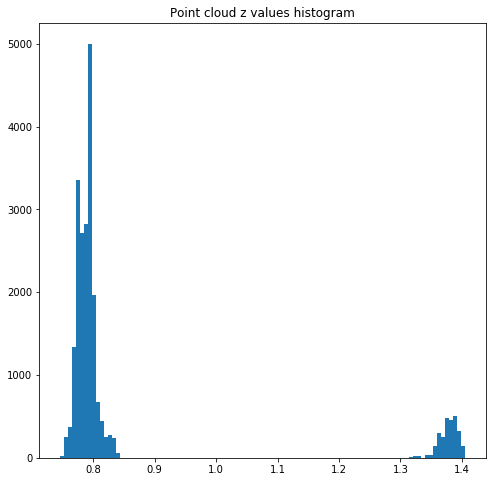

In [24]:
plt.figure(figsize=(8,8))
plt.title("Point cloud z values histogram")
z_vals = pc_crop[:,:,2].flatten()
z_vals = z_vals[np.nonzero(z_vals)]  # remove zero values from depth
counts_pc, values_pc, _ = plt.hist(z_vals, bins=100)

#### Filter the part of the histogram which is most likely to contain the bottle
This one requires some more thought than what we did with the depth image. We'd like to filter the z-values by their histogram counts but we'd also like to filter all 3 xyz coordinates for calculating the dimensions of the bottle

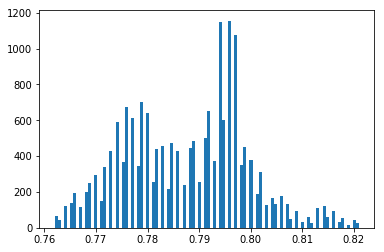

In [26]:
window = 30*1e-3
peak_idx_pc = np.argmax(counts_pc)
peak_counts_pc, peak_val_pc = counts_pc[peak_idx_pc], values_pc[peak_idx_pc]
points_bottle_pc = pc_crop.copy()
points_bottle_pc[points_bottle_pc[:,:,2] < peak_val_pc - window] = 0  # filter z values only
points_bottle_pc[points_bottle_pc[:,:,2] > peak_val_pc + window] = 0  # filter z values only
nonzero_x, nonzero_y, nonzero_z = np.nonzero(points_bottle_pc)
points_bottle_pc = points_bottle_pc[nonzero_x, nonzero_y, nonzero_z].reshape(-1, 3)  # remove zero valued z
z_vals = points_bottle_pc[:, 2]
counts_pc, values_pc, _ = plt.hist(z_vals, bins=100)

In [27]:
dist_pc = np.mean(values_pc)
print("approimate distance is: {}mm".format(round(dist_pc*1e3)))

approimate distance is: 792.0mm


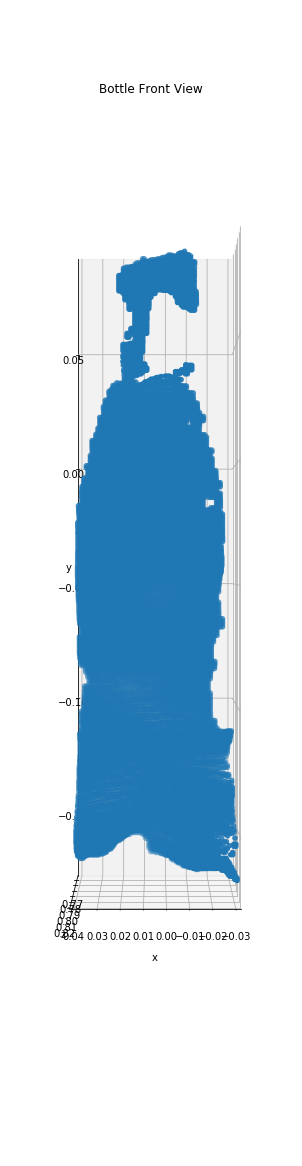

In [28]:
from mpl_toolkits.mplot3d import Axes3D
xs = points_bottle_pc[:,0]
ys = points_bottle_pc[:,1]
zs = points_bottle_pc[:,2]
fig = plt.figure(figsize=plt.figaspect(5))
ax3d = Axes3D(fig)
ax3d.set_title("Bottle Front View")
ax3d.set_xlabel("x")
ax3d.set_ylabel("z")
ax3d.set_zlabel("y")
ax3d.set_xlim(xs.min(), xs.max())
ax3d.set_ylim(zs.min(), zs.max())
ax3d.set_zlim(ys.min(), ys.max())
ax3d.scatter(xs=xs, ys=zs, zs=ys)
ax3d.view_init(elev=0, azim=90)

#### Calculate the width and height of the bottle using the filtered points `points_bottle_pc`

In [29]:
x = points_bottle_pc[:,0]
y = points_bottle_pc[:,1]
z = points_bottle_pc[:,2]
width = abs(x.max() - x.min())*1e3
height = abs(y.max() - y.min())*1e3
print("approximate dimensions are {}mm x {}mm".format(int(width), int(height)))

approximate dimensions are 70mm x 258mm


### Not bad! The actual bottle dimensions are 65mm x 265mm.
Congratulations for making it this far. Hopefully you have improved your understanding of point cloud data